## Prototype for NFAT

In [8]:
#%matplotlib inline
#%pylab 

ImportError: No module named 'matplotlib'

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np

import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named 'matplotlib'

In [4]:
import cooling
from scipy.integrate import odeint

ImportError: No module named 'scipy'

#### Integration function 

In [389]:
def dydt(y,t,params):
    # Vars
    Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n = y
    
    # V
    V= Vsignal(t,
                period=params.period,
                decay=params.decay,
                pulseAmplitude=params.pulseAmplitude)
    # Ca
    caLCC = V*params.rateLCC # placeholder for LCC, not scaled appropriately, but will do for now 
    dCa_dt = caLCC  
    dCa_dt+= caRemove(t,rate=params.removalRate) # constant leak
    
    # voltage dependent removal
    vdR = -params.vRate * (Ca-params.CaMin)*np.exp(params.eta*V/25.7)
    dCa_dt+= vdR
        
    # NFAT     
    cooling.p = params
    dNFATp_c_dt,dNFATp_n_dt,dNFATN_c_dt,dNFATN_n_dt = params.NFAT(
        Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n)
    return dCa_dt,dNFATp_c_dt,dNFATp_n_dt,dNFATN_c_dt,dNFATN_n_dt

CaEquil = 100.
Btot = 70e3 # [nM]
kf = 1e3 # [nM/s]
kb = 1. # [1/s]
CaB = Btot / (1 + (kb/kf)/CaEquil)
def dydtBuffered(y,t,params):
# Ca buffer 
    # Ca + (Btot-CaB) <--> CaB
    Btot = 70. # [uM]
    kf = 1. # [uM/s]
    kb = 1. # [1/s]
    CaB


In [378]:
def Plotting(ts,ys,params) :   

    plt.figure()
    plt.plot(ts,ys[:,1],'r-',label="NFATp_c")
    plt.plot(ts,ys[:,2],'r--',label="NFATp_n")
    plt.plot(ts,ys[:,3],'k-',label="NFATN_c")
    plt.plot(ts,ys[:,4],'k--',label="NFATN_n")
    plt.ylabel("[nM]")
    plt.legend(loc=1)
    
    plt.figure()
    Vvec = np.vectorize(Vsignal)
    Vs= Vvec(ts,
                period=params.period,
                decay=params.decay,
                pulseAmplitude=params.pulseAmplitude)
    Cas = ys[:,0]    
    fig,ax1 =plt.subplots() 
    ax1.plot(ts,Vs,'r',label= "V")  
    ax2 = ax1.twinx()
    ax2.plot(ts,Cas,label= "Ca")
    plt.legend()
    Nact = cooling.CalcNtot(Cas)
    #plt.plot(ts,Nact)
    

In [317]:
# Create periodic exponential decay
def Vsignal(t,decay=10.,pulseAmplitude=700.,period=20.):
    z = t/period - np.floor(t/period);
    z = pulseAmplitude*np.exp(-decay*z)
    return z

# Single rate 
def caRemove(t,rate=1.):
    return -rate
    
    
# Fermi dirac potential (behaves like a 'smooth' heavyside function)    
def fermiDirac(t,rate=1.,offset=50):
    ts = t-offset
    z = 1/(1 + np.exp(-ts*rate))
    return z

# creates a 'notch' by taking the difference of two fermidiracs
def notch(t,offset=50,deltaT=20):
    gr = fermiDirac(t,rate=1.,offset=offset)
    gl = fermiDirac(t,rate=1.,offset=offset+deltaT)
    g = gr -gl
    return g

# creates periodic signal with two phase decay
def caSignTwoPhase(t,decay1=1.,pulseAmplitude=700.,period=20.,
                     decay2=5.,phaseOffset=0.7):
    modulo = t/period - np.floor(t/period);
    firstPhase = pulseAmplitude*np.exp(-decay1*modulo)
    secondPhase= 1-fermiDirac(modulo,rate=decay2,offset=phaseOffset)
    result = firstPhase*secondPhase
    #z3 = z2
    return result


In [318]:
params = cooling.Params()

#### Test conservation of NFAT 
PKH Confirmed, 5/26/17

Also confirmed that the fluxes are doing the right things by shutting down reactions

0.999749738056


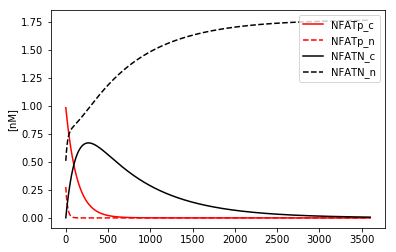

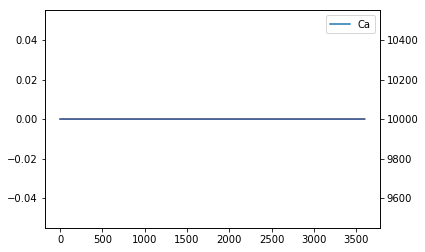

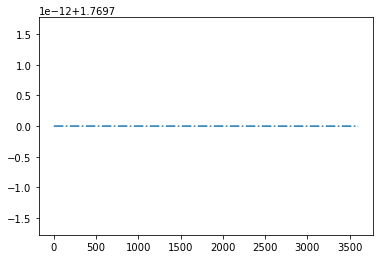

In [322]:
NFATp_c = params.NFATp_c
NFATp_n = params.NFATp_n
NFATN_c = params.NFATN_c
NFATN_n = params.NFATN_n
tsLong = np.linspace(0,60*60,36000) # 60s*60m 


## PARAMS
params = cooling.Params(NFAT=cooling.CoolingNFAT)
# set cyto/nuclear volumes to be equal 
params.Ccn = 1.
# add/remove no Ca 
params.removalRate=0.
params.vRate = 0.
params.pulseAmplitude=0.
# no nuclear flux
#params.k_f2 = params.k_f4 =0
# shut down nuclear nfat reactions
#params.k_f3=params.k_r3=0.
# shut down cytosol nfat reactions
#params.k_f1=params.k_r1=0.

# keep NFAT activated
Ca = 10000
print cooling.ActN(Ca)

# add in parameters
cooling.p = params
y0=[Ca,NFATp_c,NFATp_n,NFATN_c,NFATN_n]
#cooling.Cooling(1,1,1,1,1)
ys = odeint(dydt,y0,tsLong,args=(params,))
Plotting(tsLong,ys,cooling.p)

totNFAT = np.sum(ys[:,1:5],axis=1)
plt.figure()
plt.plot(tsLong[::10],totNFAT[::10],"-.")

#### Pulse train for Ca

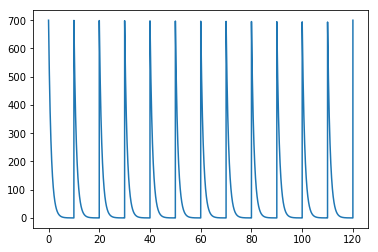

In [365]:
ts= np.linspace(0,120,12000)    
# eg like LCC
caSingle = Vsignal(ts,period=10.,pulseAmplitude=700.,decay=10.)    
plt.plot(ts,caSingle)


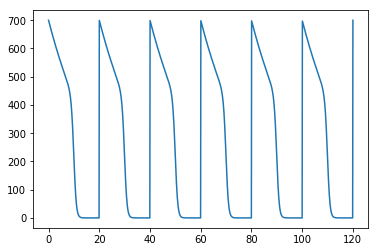

In [229]:
ts= np.linspace(0,120,1200)    
# e.g like P2X 
g = caSignTwoPhase(ts,pulseAmplitude=700.,decay1=1.0,decay2=40.,phaseOffset=0.5)    
plt.plot(ts,g)
#plt.plot(ts,notch(ts))

#### Determine compensating flux for Ca removal 

In [230]:
dt = (ts[1]-ts[0])
caAdd = np.sum(caSingle[0:199])*dt  # nM
Deltat = ts[199]-ts[0] # [s]
rate_nM_s = caAdd/Deltat # [nM/s]
rate_nM_ms= rate_nM_s
print rate_nM_ms

72.0631833838


#### Ca removal offsets Ca entry

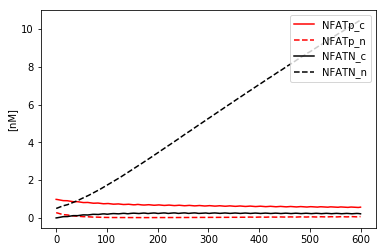

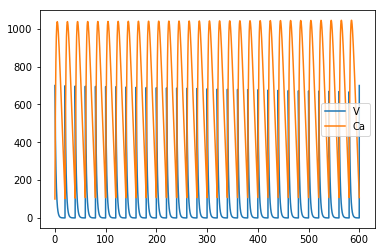

In [231]:
totSec = 60 * 10 # sec * min 
dt = .1

ts = np.linspace(0,totSec,totSec*(1/dt)) # 60s*60m
params =cooling.Params()
y0=[params.Ca,
    params.NFATp_c,
    params.NFATp_n,
    params.NFATN_c,
    params.NFATN_n]
cooling.p = params
ys = odeint(dydt,y0,ts,args=(params,))
Plotting(ts,ys,params)


#### Modulating CaM interaction 

In [448]:
params = cooling.Params()
cooling.p = params
params.K_dN = 1760
print cooling.ActN(500)


params.K_dN = 2e4
cooling.p = params
print cooling.ActN(500)

0.38822342792
0.15923911962


### Testing

In [281]:
class empty:pass
cases = dict()

In [374]:
totSec = 60 * 10 # sec * min 
#dt = .0001 #  gives [ms]
dt = .001 #  gives [ms]

ts = np.linspace(0,totSec,totSec*(1/dt)) # 60s*60m
y0=[params.Ca,
    params.NFATp_c,
    params.NFATp_n,
    params.NFATN_c,
    params.NFATN_n]

#### Control like conditions

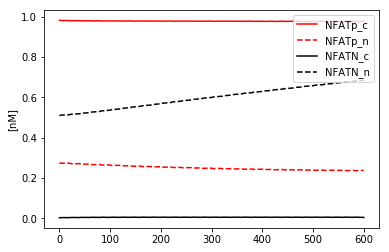

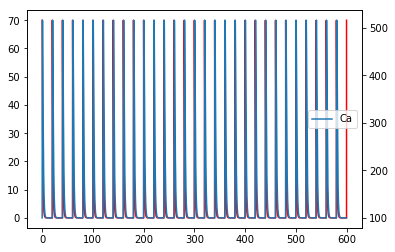

In [422]:
params =cooling.Params(cooling.CoolingNFAT,pkh=True)
ys = odeint(dydt,y0,ts,args=(params,))

case = empty()
case.yFinal = ys[-1,:]
case.params = params
cases["WT"] =case

Plotting(ts,ys,params)

#### Higher diastolic Ca


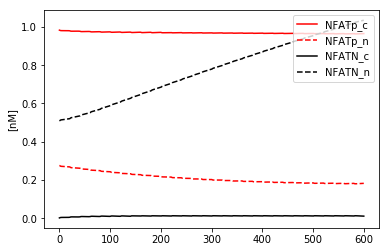

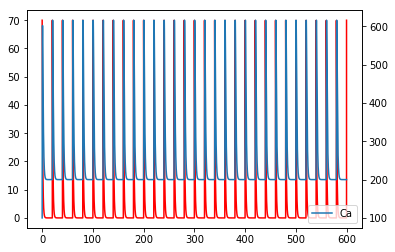

In [423]:

params =cooling.Params(cooling.CoolingNFAT,pkh=True)
#params.vRate = 0.16
params.CaMin = 200.

ys = odeint(dydt,y0,ts,args=(params,))
case = empty()
case.yFinal = ys[-1,:]
case.params = params
cases["CaDiastolic"] =case

Plotting(ts,ys,params)

#### Higher diastolic, higher amp 

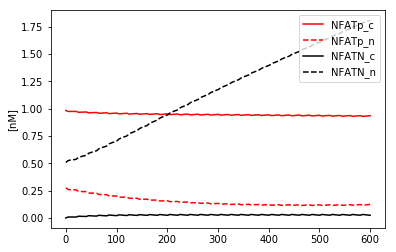

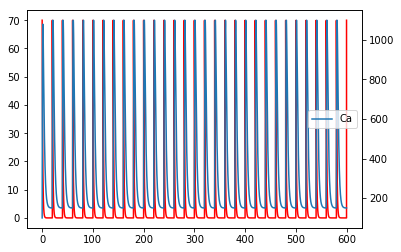

In [453]:
params =cooling.Params(cooling.CoolingNFAT,pkh=True)
params.vRate = 0.5
params.CaMin = 150.

ys = odeint(dydt,y0,ts,args=(params,))
case = empty()
case.yFinal = ys[-1,:]
case.params = params
cases["CaAmp"] =case

Plotting(ts,ys,params)

#### Modulated CaM

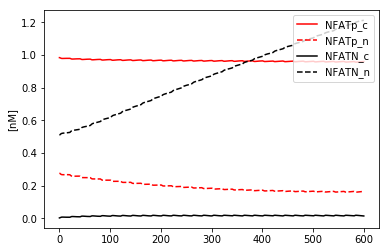

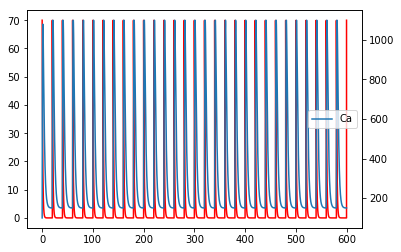

In [454]:
params =cooling.Params(cooling.CoolingNFAT,pkh=True)
params.vRate = 0.5
params.CaMin = 150.
params.K_dN = 2e4

ys = odeint(dydt,y0,ts,args=(params,))
case = empty()
case.yFinal = ys[-1,:]
case.params = params
cases["CaAmp+pCaM"] =case

Plotting(ts,ys,params)

[0.97774938086912833, 0.96506545300745294, 0.93601572518934506, 0.95928181122188094]
[0.23777684190527615, 0.182358337180864, 0.12566379735873251, 0.1643085330218077]
[0.0042063844082583174, 0.0109920108916948, 0.025713211540076646, 0.013594087486219059]
[0.68443489422555226, 1.0347684678613387, 1.8078893661702802, 1.2118965315735508]


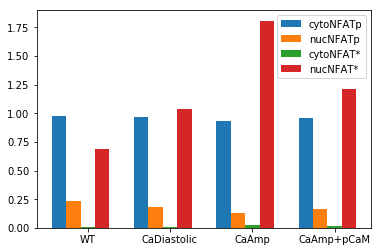

In [458]:
speciesNames = ["NFATp_cs","NFATp_ns","NFATN_cs","NFATN_ns"]
niceNames =["cytoNFATp","nucNFATp","cytoNFAT*","nucNFAT*"]
caseNames=["WT","CaDiastolic","CaAmp","CaAmp+pCaM"]

inds = np.arange( len(caseNames))
width=0.35
rectsList = []
for i,species in enumerate(speciesNames):
    caseList = []
    for key in caseNames:
        caseList.append( cases[key].yFinal[i+1] )
    print caseList    
    rects = plt.bar(inds+(i*width/2.),caseList,width=width/2.)
    rectsList.append( rects[0] )

plt.xticks(inds+width, caseNames)

#plt.legend((rects1[0], rects2[0]), ('Men', 'Women'))
#plt.legend((rectsList[0],rectsList[1]), ('Men', 'Women'))
plt.legend((rectsList), (niceNames))
plt.gcf().savefig( "nfat.png" )

print caseList